In [1]:
import numpy as np 
import pandas as pd 
import altair as alt
from venn import venn 
import upsetplot
import matplotlib.pyplot as plt
from Commons.data_processing import *

In [2]:
# get data file
file = r'.\Working_Datafiles\All_N_Glycopeptides.csv'
df = pd.read_csv(file)

# organize contents
df = df.sort_values(['dilution', 'temperature'], ascending=[False, True])

In [3]:
df

accession                                        description  checked  \
6413    P11279  Lysosome-associated membrane glycoprotein 1 OS...     True   
6414    P14625  Endoplasmin OS=Homo sapiens OX=9606 GN=HSP90B1...     True   
6415    P14625  Endoplasmin OS=Homo sapiens OX=9606 GN=HSP90B1...     True   
6416    P50454  Serpin H1 OS=Homo sapiens OX=9606 GN=SERPINH1 ...     True   
6417    P50454  Serpin H1 OS=Homo sapiens OX=9606 GN=SERPINH1 ...     True   
...        ...                                                ...      ...   
3050    Q9Y4L1  Hypoxia up-regulated protein 1 OS=Homo sapiens...     True   
3051    Q9Y4L1  Hypoxia up-regulated protein 1 OS=Homo sapiens...     True   
3052    Q9Y4L1  Hypoxia up-regulated protein 1 OS=Homo sapiens...     True   
3053    Q9Y4L1  Hypoxia up-regulated protein 1 OS=Homo sapiens...     True   
3054    Q9Y4L1  Hypoxia up-regulated protein 1 OS=Homo sapiens...     True   

     confidence           annotated_sequence            modifications  \
6413       High              [K].AANGSLR.[A]   1xHexNAc(2)Hex(9) [N3]   
6414       High     [R].EEEAIQLDGLNASQIR.[E]  1xHexNAc(2)Hex(8) [N11]   
6415       High     [R].EEEAIQLDGLNASQIR.[E]  1xHexNAc(2)Hex(6) [N11]   
6416       High             [R].SLSNSTAR.[N]         1xHexNAc(1) [N4]   
6417       High             [R].SLSNSTAR.[N]   1xHexNAc(2)Hex(8) [N4]   
...         ...                          ...                      ...   
3050       High      [R].AEPPLNASASDQGEK.[V]   1xHexNAc(2)Hex(5) [N6]   
3051       High  [K].ENGTDTVQEEEESPAEGSK.[D]   1xHexNAc(2)Hex(7) [N2]   
3052       High  [K].ENGTDTVQEEEESPAEGSK.[D]   1xHexNAc(2)Hex(8) [N2]   
3053       High  [K].ENGTDTVQEEEESPAEGSK.[D]   1xHexNAc(2)Hex(5) [N2]   
3054       High  [K].ENGTDTVQEEEESPAEGSK.[D]   1xHexNAc(2)Hex(6) [N2]   

     master_protein_accessions   rt_min       mz_da  charge  ...  \
6413                    P11279   8.9593  1277.00806     2.0  ...   
6414                    P14625  50.4359  1163.49841     3.0  ...   
6415                    P14625  51.0960  1055.46326     3.0  ...   
6416                    P50454   5.7610   519.75708     2.0  ...   
6417                    P50454   9.0568  1269.50842     2.0  ...   
...                        ...      ...         ...     ...  ...   
3050                    Q9Y4L1  24.2380  1365.57117     2.0  ...   
3051                    Q9Y4L1  27.8035  1192.79968     3.0  ...   
3052                    Q9Y4L1  27.8650  1246.81812     3.0  ...   
3053                    Q9Y4L1  28.6278  1084.76184     3.0  ...   
3054                    Q9Y4L1  28.7916  1138.78186     3.0  ...   

                 sequence   data_source  dilution  temperature   run  \
6413              AANGSLR   30C_8x_run2        8x          30C  run2   
6414     EEEAIQLDGLNASQIR   30C_8x_run2        8x          30C  run2   
6415     EEEAIQLDGLNASQIR   30C_8x_run2        8x          30C  run2   
6416             SLSNSTAR   30C_8x_run2        8x          30C  run2   
6417             SLSNSTAR   30C_8x_run2        8x          30C  run2   
...                   ...           ...       ...          ...   ...   
3050      AEPPLNASASDQGEK  60C_16x_run3       16x          60C  run3   
3051  ENGTDTVQEEEESPAEGSK  60C_16x_run3       16x          60C  run3   
3052  ENGTDTVQEEEESPAEGSK  60C_16x_run3       16x          60C  run3   
3053  ENGTDTVQEEEESPAEGSK  60C_16x_run3       16x          60C  run3   
3054  ENGTDTVQEEEESPAEGSK  60C_16x_run3       16x          60C  run3   

         sample           glycan   glycan_type  degree_sial  \
6413  BCaP_MT10  HexNAc(2)Hex(9)  High Mannose            0   
6414  BCaP_MT10  HexNAc(2)Hex(8)  High Mannose            0   
6415  BCaP_MT10  HexNAc(2)Hex(6)  High Mannose            0   
6416  BCaP_MT10        HexNAc(1)  Paucimannose            0   
6417  BCaP_MT10  HexNAc(2)Hex(8)  High Mannose            0   
...         ...              ...           ...          ...   
3050  BCaP_MT10  HexNAc(2)Hex(5)  High Mannose            0   
3051 

# <b>What are our goals?</b>

1. Demonstrate that different temperatures yield different results
- Number of glycopeptides
- Number of unique peptide backbones
- Number of unique glycans
2. Demonstrate that glycopeptide subtypes are differing in response to temperature
- Do any classes resist this trend?
3. Show that sialylated glycopeptides are adversely affected
- Show change in number of terminal residues
4. What hypotheses can we eiliminate?

In [9]:
# How does performance change in accordance with temperature?

#  information to extract: num peptides, num unique glycans, num unique peptide backbones
temps, vals, kind, dilutions = [], [], [], []

for dilution, dil_frame in iterate_contents("dilution", df[df['sample']=='BCaP_MT10'], get_item=True):
    for temp, temp_frame in iterate_contents("temperature", dil_frame, get_item=True):
        for run, run_frame in iterate_contents("run", temp_frame, get_item=True):

            unique_gly = len(run_frame.pep_mods.unique())
            dilutions.append(dilution)
            vals.append(unique_gly)
            temps.append(temp)
            kind.append("Unique Glycopeptides")

            unique_seq = len(run_frame.sequence.unique())
            dilutions.append(dilution)
            vals.append(unique_seq)
            temps.append(temp)
            kind.append("Unique Backbones")

            unique_glycans = len(run_frame.glycan.unique())
            dilutions.append(dilution)
            vals.append(unique_glycans)
            temps.append(temp)
            kind.append("Unique Glycans")

res = pd.DataFrame(
    {"Temperature": temps, "Kind": kind, "Values": vals, "Dilution": dilutions}
)

my_colors = alt.Color(
    "Temperature:N",
    scale=alt.Scale(
        domain=["30C", "45C", "60C"], range=["#6E6581", "#B0B2BB", "#6B8A97"]
    ),
)

conc_max_comparison = (
    alt.Chart(res)
    .mark_bar()
    .encode(
        x=alt.X("Temperature:N", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(Values):Q", title="Number of Identifications"),
        color=my_colors,
    )
).properties(width=45, height=150)

cmc_err_bars = (
    alt.Chart(res)
    .mark_errorbar(extent="stdev")
    .encode(
        x=alt.X("Temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(Values):Q", title=""),
    )
)

base = alt.layer(conc_max_comparison, cmc_err_bars).facet(
    column="Kind:N",
    spacing=50,
)

max_conc = base.transform_filter(alt.datum.Dilution == 1.0).properties(
    title="Temperature Differences, No Dilution"
)


all_conc = alt.vconcat()
for dilution in res.Dilution.unique():
    all_conc &= base.transform_filter(
        alt.datum.Dilution == dilution
    ).properties(title=f"Dilution = {dilution}")

# all_conc.save(r'.\Figures\ID_Rates_Dilution.svg')
all_conc


alt.VConcatChart(...)

### <b>Commentary</b>

At all concentrations tested, the numebr of unique glycopeptides decreases as temperature rises. This trend is generally conserved when considering the number of unique glycans identified, dave for the two highest concentrations. These analyses revealed comparable or elevated number of unique glycans identified at 45C with significantly reduces quantities at 60C -- these quantities are lower than those in the 30C experiments, agreeing with the majority of the dataset.

However, within each concentration and across the experiment. When looking at the venn diagrams, they are consistent at each concentration and across all experiments. Knowing this, the difference in glycopeptide identifications stems largely from the differences in glycans presented.

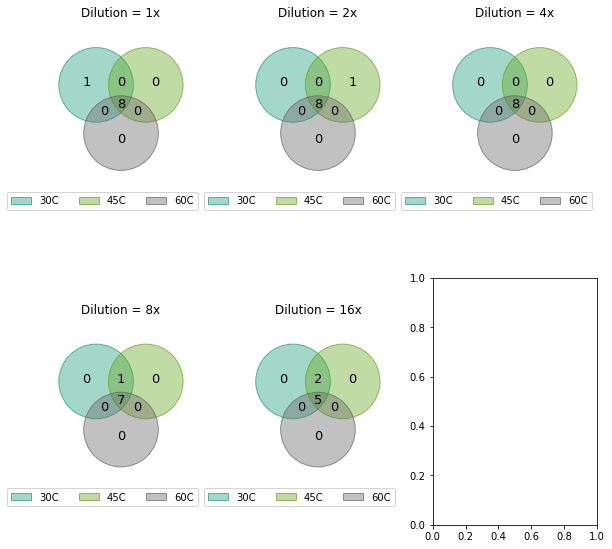

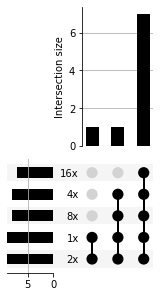

In [4]:
# How do the unique peptides compare across experiments?

global_overlap = dict()
for dilution, dil_frame in iterate_contents('dilution', df, get_item=True):
    global_overlap[dilution] = set(dil_frame.sequence.unique())
data = upsetplot.from_contents(global_overlap)


sample_overlap = dict()
dilutions = []

for dilution, dil_frame in iterate_contents("dilution", df, get_item=True):
    dilutions.append(dilution)
    d = dict()
    for temp, temp_frame in iterate_contents("temperature", dil_frame, get_item=True):
        d[temp] = set(temp_frame.sequence.unique())
    sample_overlap[dilution] = d

fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for i, dilution in enumerate(dilutions):
    ax = axs.flat[i]
    venn(sample_overlap[dilution], ax=ax, cmap='Dark2')
    ax.set_title(f'Dilution = {dilution}')
    ax.legend(list(sample_overlap[dilution].keys()), bbox_to_anchor=(1, 0), ncol=3)

upsetplot.plot(data)
None

In [6]:
glycan_sub = df[
    [
        "sequence",
        "glycan",
        "glycan_type",
        "pep_mods",
        "num_psms",
        "temperature",
        "dilution",
        "run",
    ]
]

glycan_color_scale = alt.Scale(
    domain=[
        'Sialylated',
        'Fucosylated',
        'Complex',
        'Paucimannose',
        'High Mannose',
    ],
    range=[
        '#6E6581',
        '#AF3A53',
        '#6B8A97',
        '#B0B2BB',
        '#658A64',
    ]
)

bars = (
    alt.Chart(glycan_sub)
    .mark_bar()
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="# Matches"),
        color=alt.Color("glycan_type:N", scale=glycan_color_scale),
    )
    .transform_aggregate(
        my_count='count(glycan_type)',
        groupby=['glycan_type', 'concentration', 'temperature', 'run']
    )
).properties(width=40, height=150)

err = (
    alt.Chart(glycan_sub)
    .mark_errorbar(extent='stdev')
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="# Matches"),
    )
    .transform_aggregate(
        my_count='count(glycan_type)',
        groupby=['glycan_type', 'concentration', 'temperature', 'run']
    )
)

glyc_by_concentration = alt.layer(bars, err).facet(
    column=alt.Column('glycan_type', title=''),
    row='concentration:N'
)

# glyc_by_concentration.save(r'.\Figures\GlycanCount.svg')
glyc_by_concentration

alt.FacetChart(...)

In [8]:
boxes = alt.Chart(glycan_sub).mark_boxplot().encode(
    x=alt.X('temperature:N', title=''),
    y=alt.Y('num_psms:Q', title='# PSMs'),
    color=alt.Color('glycan_type:N', scale=glycan_color_scale)
).properties(
    height=125
)
alt.layer(boxes).facet(
    row='dilution:Q', 
    column='glycan_type:N'
)

alt.FacetChart(...)

### <b>Commentary</b>

When comparing the glycan classes identified in all experiments, we notice a few prevailing trends. At higher concentrations, both sialylated glycopeptides seem to show increased identification rates at 45 dgrees before dropping at 60C. This trend may also be seen in glycopeptides with complex glycans at most concentrations and for fucosylated glycopeptides at concentrations where they were detected.

High manoose glycopeptides, though showing deviation over the course of each experiment, largely resist this trend. This could explain our previous results that demonstrated higher identification rates of high mannose glycans as temperature increases. Of note, paucimannose glycopeptides tend to demonstrate a trend counter to the overarching concensus. These glycopeptides seem to increase in identification at 45C without a significant drop off at 60C. Why?  

In [9]:
test = df[
    [
        "sequence",
        "glycan",
        "glycan_type",
        "pep_mods",
        "temperature",
        "concentration",
        "run",
        "degree_sial",
    ]
]

test = test[test.degree_sial != "0"]

sial_color_scale = alt.Scale(
    domain=["Monosialylated", "Disialylated", "Trisialylated"],
    range=["#B0B2BB", "#6B8A97", "#AF3A53"],
)


sial = (
    alt.Chart(test)
    .mark_bar()
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="Glycan Count"),
        color=alt.Color("degree_sial:N", scale=sial_color_scale),
    )
    .transform_aggregate(
        my_count="count(degree_sial):Q",
        groupby=["temperature", "run", "concentration", "degree_sial"],
    )
).properties(width=50, height=150)

err = (
    alt.Chart(test)
    .mark_errorbar(extent="stdev")
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title=''),
    )
    .transform_aggregate(
        my_count="count(degree_sial):Q",
        groupby=["temperature", "run", "concentration", "degree_sial"],
    )
)

alt.layer(sial, err).facet(
    column=alt.Column("degree_sial:O"), row=alt.Row("concentration:Q")
).save(r'.\Figures\DegreeSial.svg')


In [108]:
test_case = df.loc[
    (df.concentration==0.25) &
    (df.glycan_type=='Sialylated'), :
]

sub_30 = test_case[test_case.temperature=='30C'].pep_mods.tolist()
sub_45 = test_case[test_case.temperature=='45C'].pep_mods.tolist()
sub_60 = test_case[test_case.temperature=='60C'].pep_mods.tolist()

set(sub_60) - set(sub_45) - set(sub_30)
to_search = set(sub_45) - set(sub_30) - set(sub_60)
to_search = [x.split('_')[1] for x in to_search]
to_search
set(sub_45) - set(sub_30) - set(sub_60)
set(sub_30) - set(sub_45) - set(sub_60)

{'CVYNCSFIK_HexNAc(4)Hex(5)NeuGc(2)',
 'KLCPDCPLLAPLNDSR_HexNAc(4)Hex(5)NeuAc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(4)Hex(5)NeuGc(2)',
 'LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)Fuc(1)NeuGc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)NeuAc(3)',
 'NLTK_HexNAc(3)Hex(6)NeuAc(1)',
 'NPEYNK_HexNAc(3)Hex(4)NeuAc(1)'}

In [17]:
test_case = df.loc[
    (df.concentration==1.0) &
    (df.glycan_type=='Sialylated'), :
]


In [35]:
# find all monosialylated that are at 45C and not 30C
# for any of these species, do are there any occurrences of disalylated peptides at lower temperatures?

mono_30 = test_case.loc[
    (test_case.degree_sial=='Monosialylated') & 
    (test_case.temperature=='30C')
]
mono_45 = test_case.loc[
    (test_case.degree_sial=='Monosialylated') & 
    (test_case.temperature=='45C')
]
di_30 = test_case.loc[
    (test_case.degree_sial=='Disialylated') & 
    (test_case.temperature=='30C')
]
di_45 = test_case.loc[
    (test_case.degree_sial=='Disialylated') & 
    (test_case.temperature=='45C')
]
only_45 = mono_45[~mono_45.pep_mods.isin(mono_30.pep_mods.tolist())]
for pep in only_45.pep_mods.unique():
    peptide, glycan = pep.split('_')

    sub = di_45[di_45.sequence==peptide]
    if not sub.empty:
        print(peptide, glycan)
        print(sub[['sequence', 'glycan', 'mz_da', 'rt_min']].drop_duplicates(['sequence', 'glycan']))
        print(only_45[only_45.pep_mods==pep][['sequence', 'glycan', 'mz_da', 'rt_min']].drop_duplicates(['sequence', 'glycan']))

QNGTLSK HexNAc(5)Hex(6)NeuGc(1)
     sequence                           glycan       mz_da   rt_min
1471  QNGTLSK  HexNAc(4)Hex(5)NeuAc(1)NeuGc(1)  1484.58789  31.2492
1472  QNGTLSK          HexNAc(4)Hex(5)NeuAc(2)  1476.58777  30.6860
1473  QNGTLSK          HexNAc(4)Hex(5)NeuGc(2)  1493.08643  30.2217
     sequence                   glycan       mz_da  rt_min
1468  QNGTLSK  HexNAc(5)Hex(6)NeuGc(1)  1521.60669  25.712
QNGTLSK HexNAc(4)Hex(4)NeuAc(1)
     sequence                           glycan       mz_da   rt_min
1471  QNGTLSK  HexNAc(4)Hex(5)NeuAc(1)NeuGc(1)  1484.58789  31.2492
1472  QNGTLSK          HexNAc(4)Hex(5)NeuAc(2)  1476.58777  30.6860
1473  QNGTLSK          HexNAc(4)Hex(5)NeuGc(2)  1493.08643  30.2217
     sequence                   glycan       mz_da   rt_min
1480  QNGTLSK  HexNAc(4)Hex(4)NeuAc(1)  1247.46802  23.8138
NPEYNK HexNAc(5)Hex(6)NeuGc(1)
     sequence                           glycan       mz_da   rt_min
1507   NPEYNK          HexNAc(4)Hex(5)NeuGc(2)  1501.06

In [40]:
only_45[only_45.glycan == "HexNAc(5)Hex(6)NeuGc(1)"][['pep_mods', 'mz_da', 'delta_m_ppm', 'rt_min']]

pep_mods       mz_da  delta_m_ppm   rt_min
1468  QNGTLSK_HexNAc(5)Hex(6)NeuGc(1)  1521.60669         0.80  25.7120
1486   NPEYNK_HexNAc(5)Hex(6)NeuGc(1)  1530.08813         2.46  33.2138
1510   NPEYNK_HexNAc(5)Hex(6)NeuGc(1)  1530.58582       327.83  33.3325
1570  QNGTLSK_HexNAc(5)Hex(6)NeuGc(1)  1522.10718       329.83  26.1084

['NLTK_HexNAc(4)Hex(6)NeuAc(1)',
 'NLTK_HexNAc(3)Hex(6)NeuAc(1)',
 'CVYNCSFIK_HexNAc(4)Hex(5)NeuAc(1)',
 'NPEYNK_HexNAc(3)Hex(4)NeuAc(1)',
 'NPEYNK_HexNAc(4)Hex(5)NeuAc(1)',
 'QNGTLSK_HexNAc(3)Hex(4)NeuAc(1)',
 'QNGTLSK_HexNAc(4)Hex(5)Fuc(1)NeuAc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(5)Hex(5)NeuAc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)Fuc(1)NeuAc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(5)Hex(6)NeuAc(1)',
 'QNGTLSK_HexNAc(5)Hex(6)NeuAc(1)',
 'LCPDCPLLAPLNDSR_HexNAc(4)Hex(5)Fuc(1)NeuAc(1)',
 'QNGTLSK_HexNAc(4)Hex(5)NeuAc(1)']

In [111]:
counts = test_case.pep_mods.value_counts()
valid = counts[counts.values == 3].keys()
subset = test_case[test_case.pep_mods.isin(valid)]
subset.to_csv(r'.\Working_DataFiles\30_only_2.csv', index=False)
subset

accession                                        description  checked  \
1110    Q3SZR3  Alpha-1-acid glycoprotein OS=Bos taurus OX=991...     True   
1180    Q3SZR3  Alpha-1-acid glycoprotein OS=Bos taurus OX=991...     True   
1233    Q3SZR3  Alpha-1-acid glycoprotein OS=Bos taurus OX=991...     True   

     confidence annotated_sequence  \
1110       High  [K].CVYNCSFIK.[I]   
1180       High  [K].CVYNCSFIK.[I]   
1233       High  [K].CVYNCSFIK.[I]   

                                          modifications  \
1110  2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)N...   
1180  2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)N...   
1233  2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)N...   

     master_protein_accessions   rt_min       mz_da  charge  ...   sequence  \
1110                    Q3SZR3  43.2355  1142.43469       3  ...  CVYNCSFIK   
1180                    Q3SZR3  61.8448  1714.10413       2  ...  CVYNCSFIK   
1233                    Q3SZR3  43.4558  1143.10278       3  ...  CVYNCSFIK   

       data_source  temperature   run concentration dilution  \
1110  025_30C_Run3          30C  Run3          0.25       4x   
1180  025_30C_Run1          30C  Run1          0.25       4x   
1233  025_30C_Run2          30C  Run2          0.25       4x   

                       glycan  glycan_type   degree_sial  \
1110  HexNAc(4)Hex(5)NeuGc(2)   Sialylated  Disialylated   
1180  HexNAc(4)Hex(5)NeuGc(2)   Sialylated  Disialylated   
1233  HexNAc(4)Hex(5)NeuGc(2)   Sialylated  Disialylated   

                               pep_mods  
1110  CVYNCSFIK_HexNAc(4)Hex(5)NeuGc(2)  
1180  CVYNCSFIK_HexNAc(4)Hex(5)NeuGc(2)  
1233  CVYNCSFIK_HexNAc(4)Hex(5)NeuGc(2)  

[3 rows x 47 columns]

In [52]:
counts = test_case.pep_mods.value_counts()
valid = counts[counts.values == 5].keys()
subset = test_case[test_case.pep_mods.isin(valid)]
subset.to_csv(r'.\Working_DataFiles\for_eic_extract_notfound.csv', index=False)

In [11]:
glycan_color_scale = alt.Scale(
    domain=[
        'Sialylated',
        'Fucosylated',
        'Complex',
        'Paucimannose',
        'High Mannose',
    ],
    range=[
        '#6E6581',
        '#AF3A53',
        '#6B8A97',
        '#B0B2BB',
        '#658A64',
    ]
)

selection = alt.selection_interval(bind='scales')

ticks = alt.Chart(df).mark_tick(thickness=5).encode(
    x=alt.X('avg_rt:Q', title='Average Retention Time (min)'),
    y=alt.Y('temperature:N', title='Tempeature'),
    color=alt.Color('glycan_type:N', scale=glycan_color_scale),
    tooltip=['pep_mods']
).transform_aggregate(
    avg_rt='mean(rt_min)',
    groupby=['dilution', 'temperature', 'pep_mods', 'glycan_type']
).properties(
    width=1200
).interactive().add_selection(
    selection
)

alt.layer(ticks).facet(
    row='dilution:N'
)

alt.FacetChart(...)

In [116]:
df[(df.mz_da > 1138) & (df.mz_da < 1142)]

accession                                        description  checked  \
946    Q3SZR3  Alpha-1-acid glycoprotein OS=Bos taurus OX=991...     True   

    confidence annotated_sequence  \
946       High  [K].CVYNCSFIK.[I]   

                                         modifications  \
946  2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)N...   

    master_protein_accessions   rt_min       mz_da  charge  ...   sequence  \
946                    Q3SZR3  52.1166  1141.94934       2  ...  CVYNCSFIK   

     data_source  temperature   run concentration dilution  \
946  05_30C_Run2          30C  Run2           0.5       2x   

                      glycan  glycan_type   degree_sial  \
946  HexNAc(4)Hex(5)NeuGc(2)   Sialylated  Disialylated   

                              pep_mods  
946  CVYNCSFIK_HexNAc(4)Hex(5)NeuGc(2)  

[1 rows x 47 columns]

In [61]:
import re 
def get_saccharides(glycans):
    res = pd.DataFrame()

    for glycan in glycans:
        reg = re.compile(r'(\w*\()(\d*\))')
        matches = re.finditer(reg, glycan)
        d = dict()
        for match in matches:
            d[match.group(1)[:-1]] = match.group(2)[:-1]
        res = pd.concat([res, pd.DataFrame(d, index=range(1))])
    return res.fillna(0)

In [62]:
get_saccharides(test_case.glycan)

HexNAc Hex NeuAc Fuc NeuGc
0       3   6     1   0     0
0       5   6     2   0     0
0       5   6     2   0     0
0       4   5     2   0     0
0       5   6     3   0     0
..    ...  ..   ...  ..   ...
0       5   6     1   0     0
0       4   5     2   0     0
0       4   5     0   0     2
0       4   5     1   0     0
0       3   4     1   0     0

[185 rows x 5 columns]